# Fitting Curly's sphere spectrum in water sims
in order to check consistency with my simulations

In [47]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [48]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [49]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


In [50]:
pixel_num = 300
boundary_pixel_coords_in_nm = [
    -750,
    750,
    -750,
    750,
    ]
pixel_size = (
    boundary_pixel_coords_in_nm[1] - boundary_pixel_coords_in_nm[0]
    )/(pixel_num)

exp_obs_pts = diffi.observation_points(
    boundary_pixel_coords_in_nm[0]*cm_per_nm, 
    boundary_pixel_coords_in_nm[1]*cm_per_nm, 
    boundary_pixel_coords_in_nm[2]*cm_per_nm, 
    boundary_pixel_coords_in_nm[3]*cm_per_nm, 
    300,) ## cm_per_m

img_extent = [
    boundary_pixel_coords_in_nm[0] - .5*pixel_size,
    boundary_pixel_coords_in_nm[1] + .5*pixel_size,
    boundary_pixel_coords_in_nm[2] - .5*pixel_size,
    boundary_pixel_coords_in_nm[3] + .5*pixel_size,
]

In [51]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'simple_sphere_sims_011720',
    'reanysimulationyouwantmetodo'
    )

I guess the first thing I should do is compare Curly's sphere spectrum the the one I have been using. I might need to find my JC spec. 

In [106]:
## Load Curl's spectrum
import h5py

AuND_D80_scat_Spectra = {}
f = h5py.File(
    os.path.join(path_to_data, "AuND_D80_scat_Spectra.mat"), 
    'r')

for key, val in f.items():
    AuND_D80_scat_Spectra[key] = np.array(val)[0]

In [107]:
## Get my spectrum 
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'sphere_dip_spectrum',
    )

my_sphere_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'sph_scat_spec.mat'
    ))
## Convert to eV and plot spectra 
my_hw = 1240/my_sphere_spec['enei'][0]
my_spec = my_sphere_spec['sca']

# plt.figure(figsize=(2,1.5), dpi=150)
# for i, spectrum in enumerate(spec.T):
#     plt.plot(hw, spectrum)
# plt.xlabel('eV')
# plt.ylabel('$\mathrm{nm}^2$')
# plt.title('JC Sphere Scattering')

In [108]:
## Check key names in loaded Curly spectrum file
AuND_D80_scat_Spectra.keys()

dict_keys(['f', 'source_intensity', 'source_power', 'transabsorp', 'transscat'])

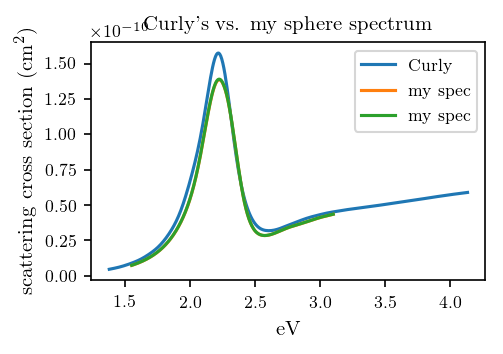

In [109]:
## Plot Curly's sphere spectrum
sigma_scat_data = (
    AuND_D80_scat_Spectra['transscat'] 
    * AuND_D80_scat_Spectra['source_power']
    / AuND_D80_scat_Spectra['source_intensity']
    )

curly_hw = hbar * 2 * np.pi * AuND_D80_scat_Spectra['f']

## rescale Curly's spec to cm^2
cmsqrd_on_msqrd = (100)**2
curly_spec = sigma_scat_data * cmsqrd_on_msqrd

## Rescale my spec to cm^2
cmsqrd_on_nmsqrd = (1e-7)**2.
my_spec_cm2 = my_spec * cmsqrd_on_nmsqrd

plt.figure(dpi=150)
plt.plot(curly_hw, curly_spec, label='Curly')
plt.xlabel('eV')
plt.ylabel('scattering cross section ($\mathrm{cm}^2$)')
plt.title("Curly's vs. my sphere spectrum")

for i, spectrum in enumerate(my_spec_cm2.T):
    plt.plot(my_hw, spectrum, label='my spec')

plt.legend()

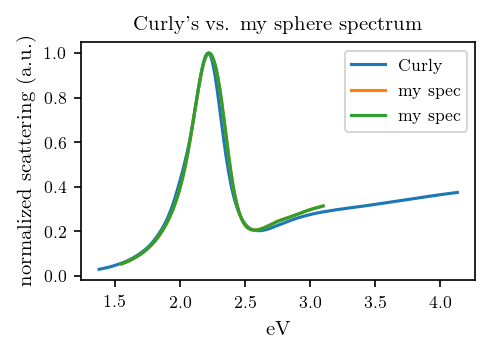

In [110]:
plt.figure(dpi=150)
plt.plot(curly_hw, curly_spec/curly_spec.max(), label='Curly')
plt.xlabel('eV')
plt.ylabel('normalized scattering (a.u.)')
plt.title("Curly's vs. my sphere spectrum")

for i, spectrum in enumerate(my_spec_cm2.T):
    plt.plot(my_hw, spectrum/spectrum.max(), label='my spec')

plt.legend()

## Fitting the spectra to get oscillator parameters

In [14]:
my_spec_cm2.shape

(500, 2)

In [15]:
my_hw.shape

(500,)

array([12.29925573,  9.49075495,  0.20932679, 41.11919967])

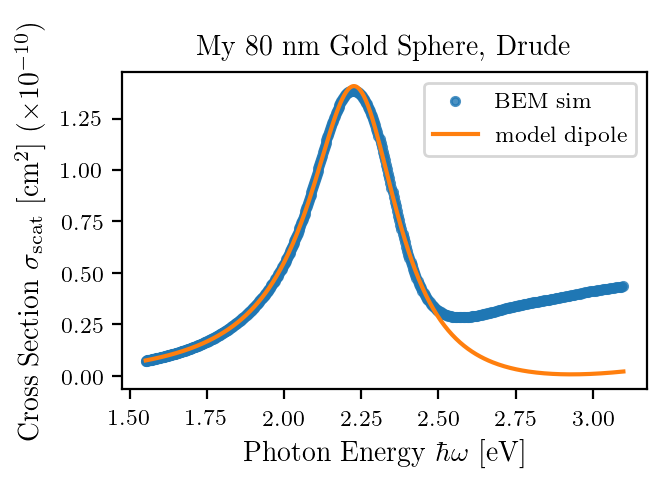

In [112]:
sphere_spec = my_spec_cm2

params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

# eneis = 1240/sphere_spec['enei'][0, :]
eneis = my_hw
spec = sphere_spec.T[0, :]/spit.cm_per_nm**2.

high_enei_cutoff = 2.5

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_Mie_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    eneis, 
    *result['x'],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )

norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
# norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'My 80 nm Gold Sphere, Drude')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

In [100]:
eneis[np.argmax(fit_result)]

2.2185083793472917

array([12.62121152,  9.55352709,  0.20347647, 42.20215353])

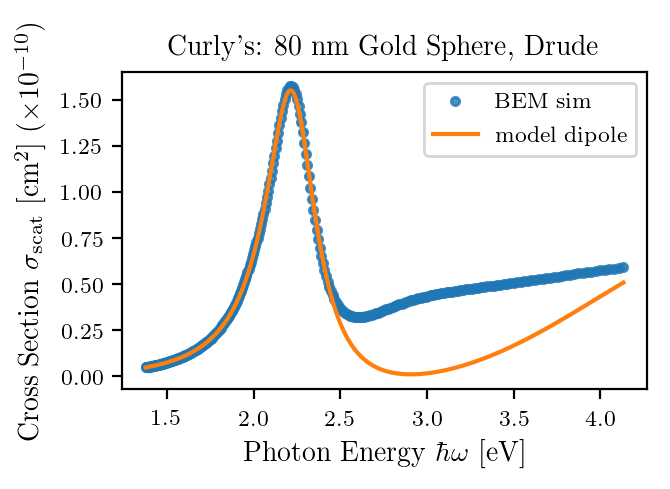

In [113]:
## Fit Curly's spectrum
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

# eneis = 1240/sphere_spec['enei'][0, :]
eneis = curly_hw
spec = curly_spec/cmsqrd_on_nmsqrd

high_enei_cutoff = 2.5

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_Mie_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    eneis, 
    *result['x'],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
# norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r"Curly's: 80 nm Gold Sphere, Drude")
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

In [19]:
def gau_cost_func(_p, *_a):
#     print(_a[0])
    return spit.hiengau_cost_func(_p, 
        model_cross_section=cp.sigma_scat_Mie_sphere, 
        *_a,)

array([14.22822322, 10.01514838,  0.20064218, 41.65820064,  0.38415112,
        2.8998308 ,  0.34575848])

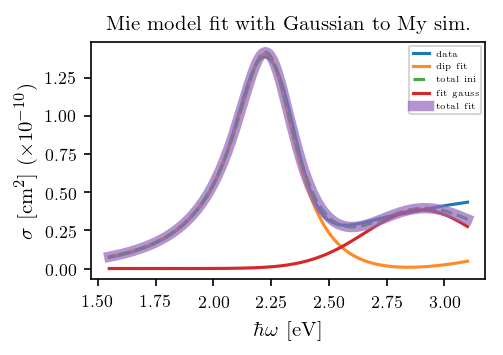

In [132]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([14.22822317, 10.01514836,  0.20064218, 41.65820061,  0.38415112,
        2.8998308 ,  0.34575848])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

hw = my_hw
sigma_scat_data = sphere_spec.T[0, :]/spit.cm_per_nm**2.

## Reduce fit range
energy_cutoff = 3
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    gau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, .01,  1.75, 0],
        [18, 20,     1,  50,  .8,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    hw, 
    *result['x'][:-3],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
ini_guess =  spit.sphere_fit_fun(
    hw, 
    *ini_guess_params[:-3],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
# norm_fit_result = fit_result/fit_result.max()
# fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
# ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*(spit.cm_per_nm**2), label='data')

## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='--', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
# plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
# plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Mie model fit with Gaussian to My sim.')
plt.legend(fontsize=4)
ax = plt.gca()
label_offset(ax, "y")
result['x']

array([18.        , 10.91935755,  0.18469379, 43.19738362,  0.38051925,
        2.94921603,  0.60680815])

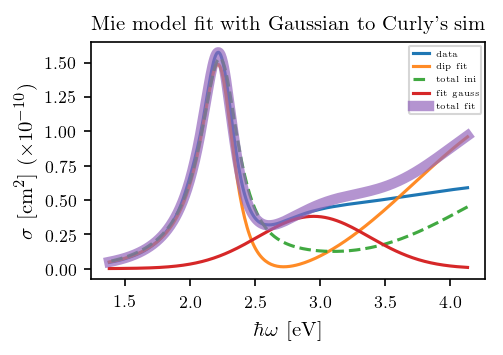

In [116]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([12.52345519,  9.55528408,  0.2083947 , 41.19693838,  0.15347945,
        2.60005114,  0.7854361])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

hw = curly_hw
sigma_scat_data = curly_spec/cmsqrd_on_nmsqrd

## Reduce fit range
energy_cutoff = 2.8
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    gau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, .01,  1.75, 0],
        [18, 20,     1,  50,  .8,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    hw, 
    *result['x'][:-3],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
ini_guess =  spit.sphere_fit_fun(
    hw, 
    *ini_guess_params[:-3],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
# norm_fit_result = fit_result/fit_result.max()
# fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
# ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*(spit.cm_per_nm**2), label='data')

## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='--', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
# plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
# plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r"Mie model fit with Gaussian to Curly's sim")
plt.legend(fontsize=4)
ax = plt.gca()
label_offset(ax, "y")
result['x']

array([17.72548286, 10.8543082 ,  0.18572353, 43.22873954,  0.36243695,
        2.89345193,  0.54291292])

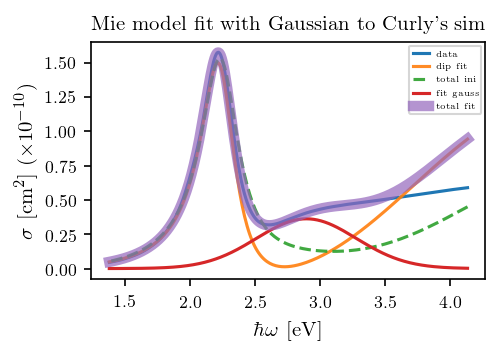

In [118]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([12.52345519,  9.55528408,  0.2083947 , 41.19693838,  0.15347945,
        2.60005114,  0.7854361])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

hw = curly_hw
sigma_scat_data = curly_spec/cmsqrd_on_nmsqrd

## Reduce fit range
energy_cutoff = 3.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    gau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, .01,  1.75, 0],
        [18, 20,     1,  50,  .8,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    hw, 
    *result['x'][:-3],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
ini_guess =  spit.sphere_fit_fun(
    hw, 
    *ini_guess_params[:-3],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
# norm_fit_result = fit_result/fit_result.max()
# fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
# ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*(spit.cm_per_nm**2), label='data')

## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='--', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
# plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
# plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r"Mie model fit with Gaussian to Curly's sim")
plt.legend(fontsize=4)
ax = plt.gca()
label_offset(ax, "y")
result['x']

## Realized I was looking at the near field spectrum

In [95]:
## Load Curl's spectrum
import h5py

AuND_D80_scat_powff = {}
f = h5py.File(
    os.path.join(path_to_data, "AuND_D80_scat_powff.mat"), 
    'r')

for key, val in f.items():
    AuND_D80_scat_powff[key] = np.array(val)

In [96]:
## Get my spectrum 
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'sphere_dip_spectrum',
    )

my_sphere_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'sph_scat_spec.mat'
    ))
## Convert to eV and plot spectra 
my_hw = 1240/my_sphere_spec['enei'][0]
my_spec = my_sphere_spec['sca']

In [97]:
## Check key names in loaded Curly spectrum file
AuND_D80_scat_powff.keys()

dict_keys(['NA', 'T', 'f', 'index', 'powff', 'res', 'source_power'])

In [98]:
for i in AuND_D80_scat_powff.keys():
    print(AuND_D80_scat_powff[i].shape)

(1, 1)
(1, 300)
(1, 300)
(1, 1)
(300, 1)
(1, 1)
(1, 300)


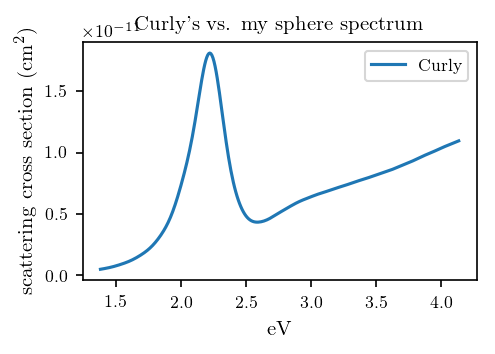

In [130]:
## Plot Curly's sphere spectrum
sigma_scat_data = (
    AuND_D80_scat_powff['powff'][:,0]
#     * AuND_D80_scat_powff['source_power'][0,:]
#     / AuND_D80_scat_Spectra['source_intensity']
    )

curly_hw = hbar * 2 * np.pi * AuND_D80_scat_powff['f'][0]

## rescale Curly's spec to cm^2
cmsqrd_on_msqrd = (100)**2
curly_spec = sigma_scat_data * cmsqrd_on_msqrd

## Rescale my spec to cm^2
cmsqrd_on_nmsqrd = (1e-7)**2.
my_spec_cm2 = my_spec * cmsqrd_on_nmsqrd

plt.figure(dpi=150)
plt.plot(curly_hw, curly_spec, label='Curly')
plt.xlabel('eV')
plt.ylabel('scattering cross section ($\mathrm{cm}^2$)')
plt.title("Curly's vs. my sphere spectrum")

# for i, spectrum in enumerate(my_spec_cm2.T):
#     plt.plot(my_hw, spectrum, label='my spec')

plt.legend()

Hmmm, weird order of magnitude, but i guess its because of the NA=0.6?

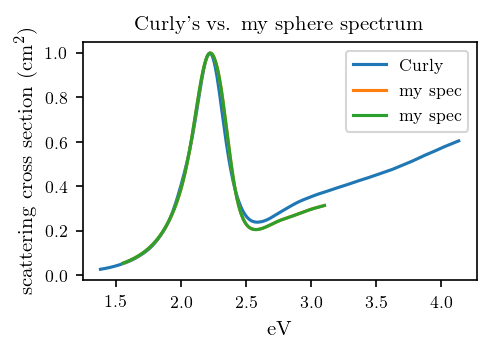

In [131]:
## Plot Curly's sphere spectrum
sigma_scat_data = (
    AuND_D80_scat_powff['powff'][:,0]
#     * AuND_D80_scat_powff['source_power'][0,:]
#     / AuND_D80_scat_Spectra['source_intensity']
    )

curly_hw = hbar * 2 * np.pi * AuND_D80_scat_powff['f'][0]

## rescale Curly's spec to cm^2
cmsqrd_on_msqrd = (100)**2
curly_spec = sigma_scat_data * cmsqrd_on_msqrd

## Rescale my spec to cm^2
cmsqrd_on_nmsqrd = (1e-7)**2.
my_spec_cm2 = my_spec * cmsqrd_on_nmsqrd

plt.figure(dpi=150)
plt.plot(curly_hw, curly_spec/np.max(curly_spec), label='Curly')
plt.xlabel('eV')
plt.ylabel('scattering cross section ($\mathrm{cm}^2$)')
plt.title("Curly's vs. my sphere spectrum")

for i, spectrum in enumerate(my_spec_cm2.T):
    plt.plot(my_hw, spectrum/np.max(spectrum), label='my spec')

plt.legend()

Half angle at 73.5